In [1]:
!ls

alphas-betas-assets.csv
analysis-starting-point.ipynb
banks-performance-in-market.ipynb
companies-by-industry.csv
creating-risk-optimal-portfolio.docx
creating-risk-optimal-portfolio.xlsx
dailyarchive.py
data-read-dse.ipynb
investmen-body-chapter-8-index-model.md
optimal-portfolio-creation.ipynb
optimal-portfolio-with-two-risky-asset.ipynb
optimal.xlsx
past-eight-months.ipynb
requirements.txt
return.csv
return_avg.csv
return_hor.csv
return_shrp.csv
single-index-model-with-alphas-betas-portfolio.ipynb
single-index-portfolio-creation.ipynb
stocks-pivoted-dataframe.csv
submission-single-index-model-active-passive.ipynb
t-bill.csv
venv


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(rc={'figure.figsize': (11.7,8.27)})
import statsmodels.api as sm
from pprint import pprint as print

In [35]:
#risk_free
risk_free = .06
weekly_risk_free = (1+risk_free)**(1/52) - 1
weekly_risk_free*52

0.058301567106710195

In [9]:
df = pd.read_csv('./stocks-pivoted-dataframe.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [14]:
assets_df = df.loc[:, ['UPGDCL', 'DSEX', 'MONNOSTAF']].fillna?


Object `fillna` not found.


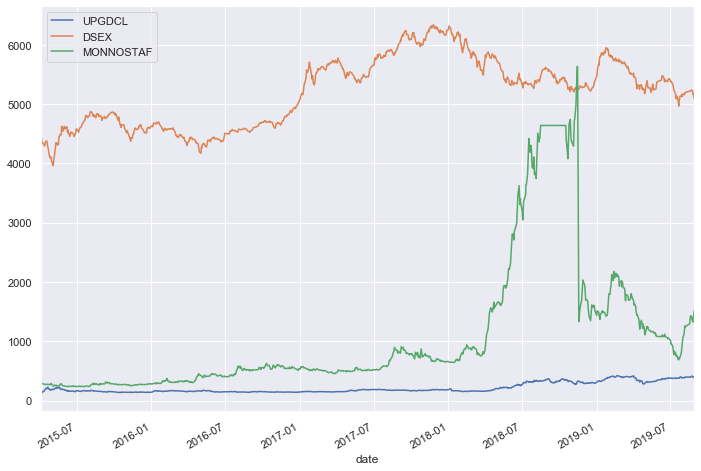

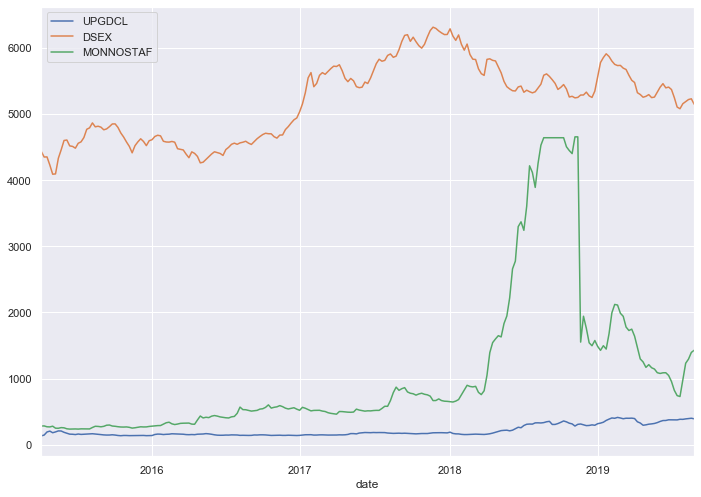

In [25]:
assets_df = df.loc[:, ['UPGDCL', 'DSEX', 'MONNOSTAF']].fillna(method='ffill').dropna()
assets_df.plot()
assets_week_df = assets_df.resample('W').mean()
assets_week_df = assets_week_df.dropna()
assets_week_df.plot()

In [33]:
len(assets_week_df['2018-01-01':'2019-01-01'])

52

array(['UPGDCL', 'DSEX', 'MONNOSTAF'], dtype=object)


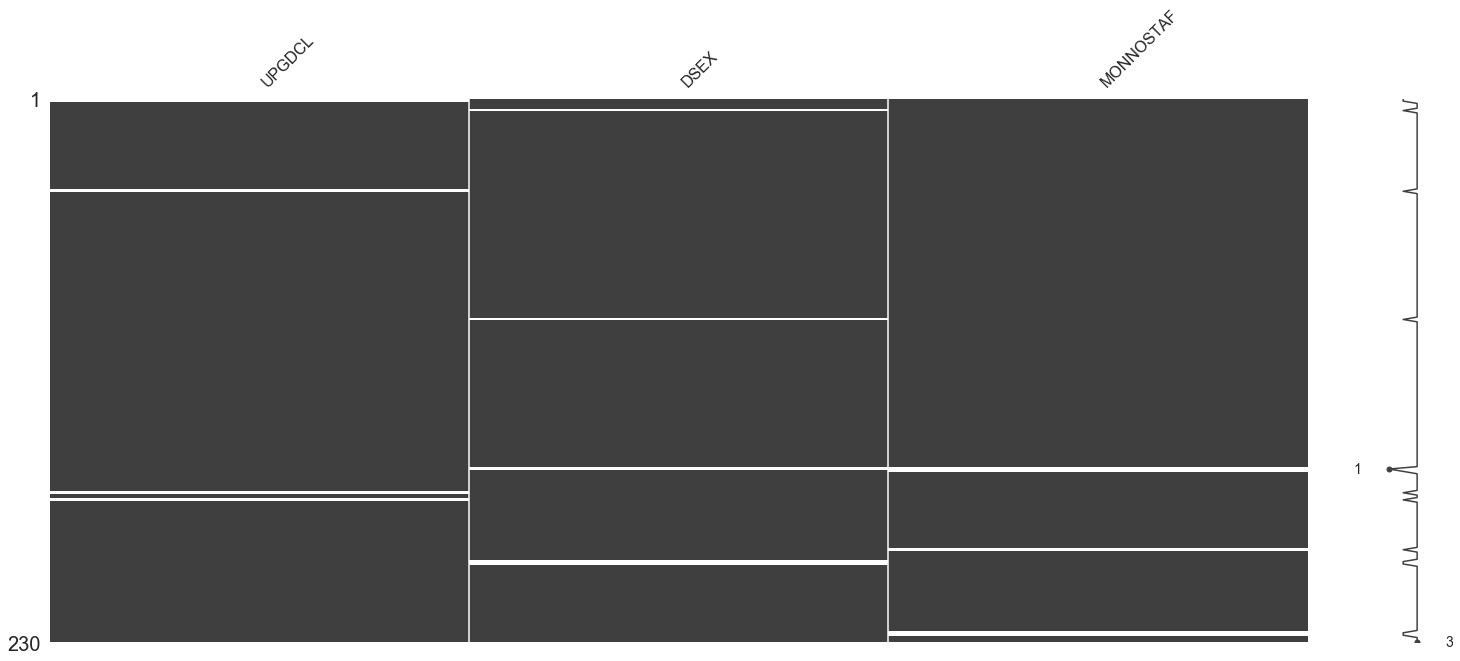

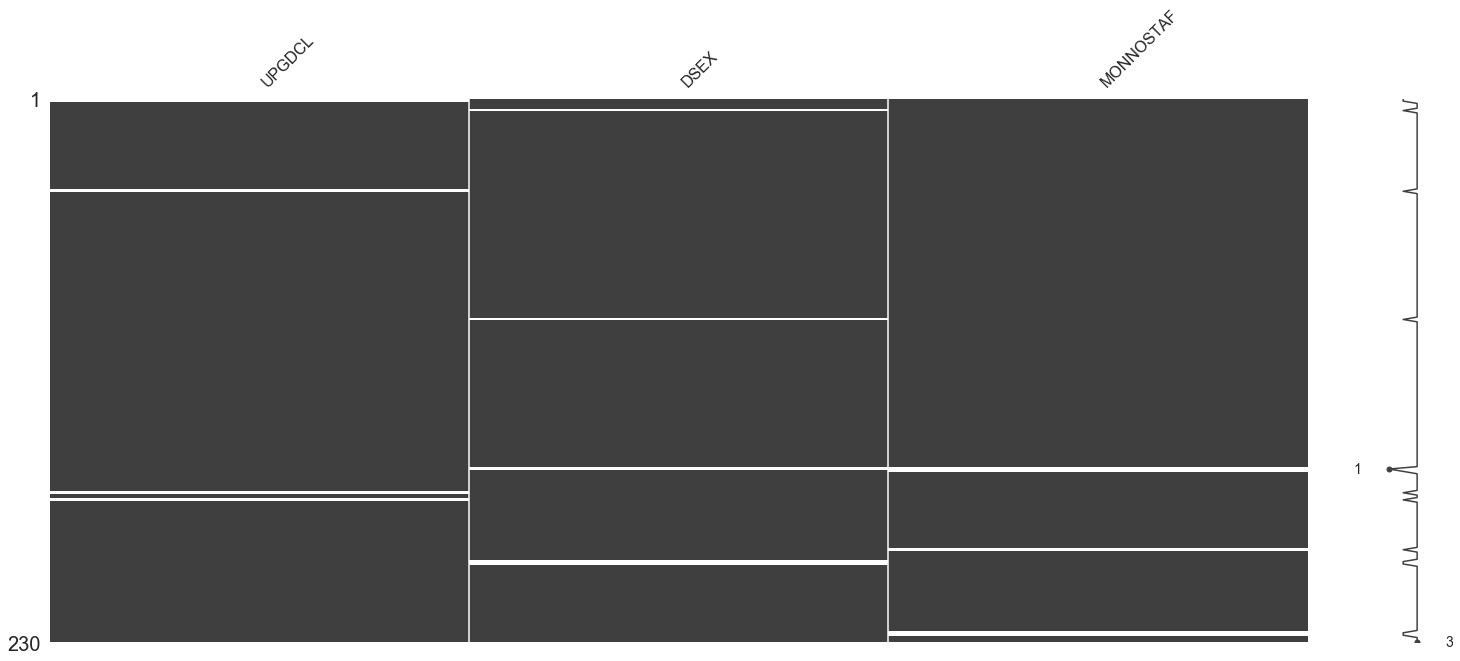

In [98]:
weekly_r = assets_week_df.pct_change().dropna()
print(weekly_r.columns.values)
for symbol in weekly_r.columns.values:
    weekly_r[symbol] = weekly_r[symbol][weekly_r[symbol].between(weekly_r[symbol].quantile(0), weekly_r[symbol].quantile(.98))]
msno.matrix(weekly_r)
weekly_r.fillna(method='ffill').fillna(method='bfill')
msno.matrix(weekly_r)
    
    

            UPGDCL   DSEX  MONNOSTAF
date                                
2015-04-05     NaN    NaN        NaN
2015-04-12   0.092 -0.019      0.006
2015-04-19   0.316  0.000     -0.046
2015-04-26   0.067 -0.028     -0.007
2015-05-03  -0.118 -0.033      0.040
...            ...    ...        ...
2019-08-04  -0.003  0.015      0.348
2019-08-11   0.018  0.006      0.253
2019-08-18   0.011  0.006      0.051
2019-08-25   0.014  0.002      0.078
2019-09-01  -0.021 -0.016      0.024

[231 rows x 3 columns]
              UPGDCL      DSEX  MONNOSTAF
date                                     
2015-04-12  0.091004 -0.019851   0.004740
2015-04-19  0.314695 -0.000738  -0.046793
2015-04-26  0.065856 -0.029517  -0.008589
2015-05-03 -0.119253 -0.033759   0.039202
2015-05-10  0.065912 -0.000059  -0.108139
...              ...       ...        ...
2019-08-04 -0.003873  0.013787   0.346877
2019-08-11  0.016920  0.004824   0.251626
2019-08-18  0.010003  0.005142   0.050284
2019-08-25  0.012839  0.001028   

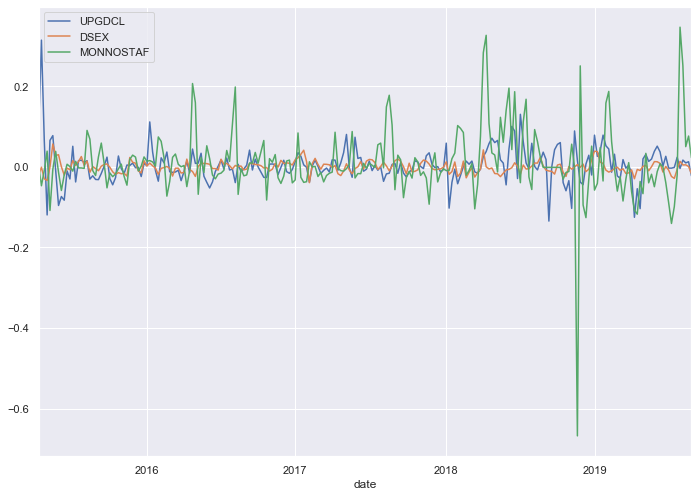

In [99]:
return_weekly = assets_week_df.pct_change()
print(round(return_weekly, 3))
return_weekly = return_weekly - weekly_risk_free
return_weekly =  return_weekly.dropna()
print(return_weekly)
return_weekly.plot()
return_weekly.to_clipboard()

,alpha,beta,market premium,regression variance,residual variance,symbol,total variance
0,0.004713,0.682512,-0.024229,0.004843,0.093855,"[UPGDCL, MONNOSTAF]",0.099129


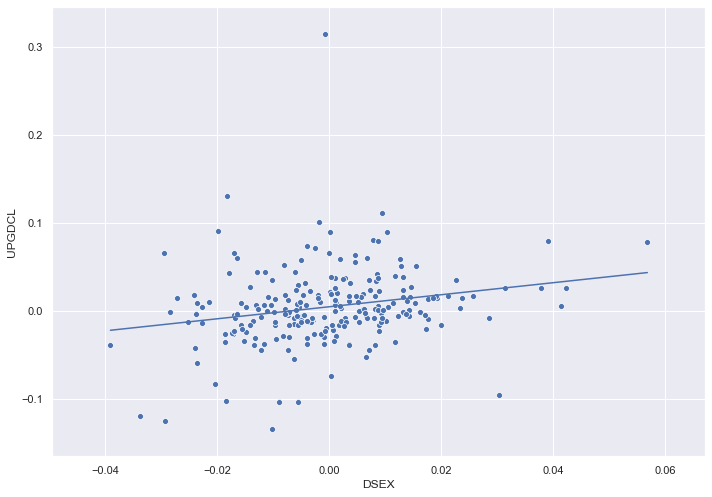

In [121]:
ols_table = pd.DataFrame()
x = return_weekly['DSEX']
X = sm.add_constant(x)
Y_up = return_weekly['UPGDCL']
#Y_mo = return_weekly['MONNOSTAF']
model_up = sm.OLS(Y_up,X).fit()
#model_mo = sm.OLS(Y_mo, X).fit()
sns.scatterplot(return_weekly['DSEX'], return_weekly['UPGDCL'])
#sns.scatterplot(return_weekly['DSEX'], return_weekly['MONNOSTAF'])
sns.lineplot(x,model_up.predict(X))
#sns.lineplot(x,model_mo.predict(X))
ols_table = ols_table.append({
    'symbol' : 'UPGDCL',
    'alpha' :    model_up.params[0],
    'beta' : model_up.params[1],
    'regression variance': model_up.ess/len(return_weekly.index) * 52,
    'residual variance': model.ssr / len(return_weekly.index) * 52, 
    'total variance': return_weekly.UPGDCL.var() * 52,
    'market premium': (return_weekly.DSEX.apply(lambda x: x +1).cumprod().iloc[-1]**(52/len(return_weekly.index)) -1)
    
    
}, ignore_index = True)
ols_table.head()

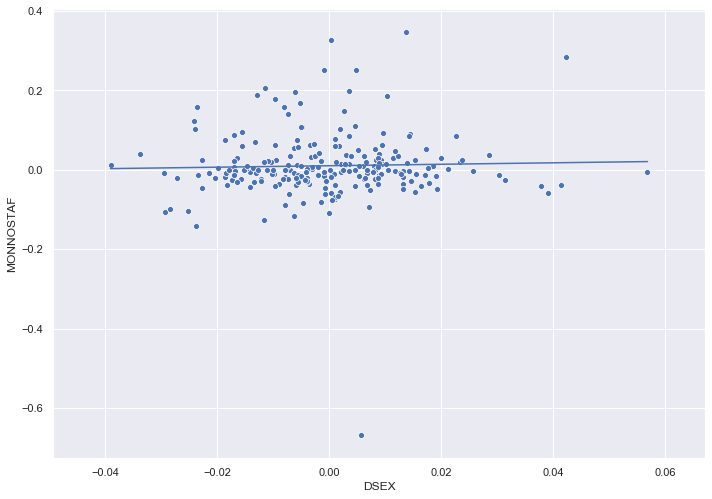

In [116]:
x = return_weekly['DSEX']
X = sm.add_constant(x)
#Y_up = return_weekly['UPGDCL']
Y_mo = return_weekly['MONNOSTAF']
#model_up = sm.OLS(Y_up,X).fit()
model_mo = sm.OLS(Y_mo, X).fit()
#sns.scatterplot(return_weekly['DSEX'], return_weekly['UPGDCL'])
sns.scatterplot(return_weekly['DSEX'], return_weekly['MONNOSTAF'])
#sns.lineplot(x,model_up.predict(X))
sns.lineplot(x,model_mo.predict(X))
ols_table = ols_table.append({
    'symbol': 'MONNOSTAF',
    'alpha': model_mo.params[0],
    'beta': model_mo.params[1],
    'regression variance': model_mo.ess/len(return_weekly.index) * 52,
    'residual variance': model_mo.ssr/len(return_weekly.index) * 52,
    'total variance': return_weekly.MONNOSTAF.var() * 52,
    'market premium': return_weekly.DSEX.apply(lambda x: x+1).cumprod().iloc[-1] ** (52/len(return_weekly.index)) -1
}, ignore_index=True)

In [112]:
ols_table.head()

,alpha,beta,market premium,regression variance,residual variance,total variance,symbol
0,0.004713,0.682512,-0.024229,0.004843,0.093855,0.099129,NaN
1,0.010316,0.184221,-0.024229,0.000353,0.373001,0.374985,MONNOSTAF


In [76]:
return_weekly['MONNOSTAF'] = return_weekly['MONNOSTAF'][return_weekly['MONNOSTAF'].between(return_weekly['MONNOSTAF'].quantile(.01), return_weekly['MONNOSTAF'].quantile(.98))]

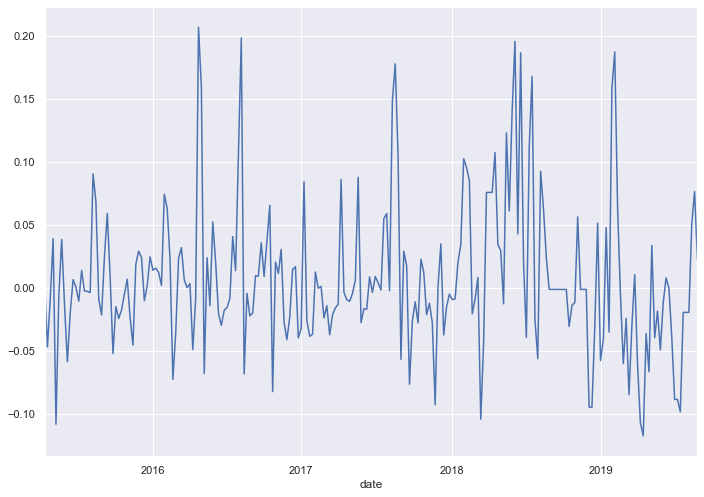

In [82]:
return_weekly['MONNOSTAF'] = return_weekly['MONNOSTAF'].fillna(method='ffill')
return_weekly['MONNOSTAF'].plot()

```
append({'symbol':symbol, 
                              'Data Length': data_size,
                              'Alpha': model.params[0], 
                              'Beta': model.params[1],
                              'Regression Variance': (model.ess/data_size) * 252, 
                              'Residual Variance': (model.ssr / data_size) * 252,
                              'Total Variance': (model.centered_tss / data_size) * 252,
                             'Market Premium S': market_premium_simple, 
                              'Market Premium C': market_premium_compound,
                              'Market Variance': market_var, 
                              'Symbol Variance': symbol_var 
                                 }, ignore_index=True)
                                 ```